**Librerías a utilizar en el código**

In [1]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torch.nn.functional as F

**Extracción de características**

Primero extraemos la media y desviación estándar de las imágenes para normalizar nuestra data. Posteriormente a esto transformamos la data a escala de grises, un formato de 64x64 pixeles, a tensor y normalizada. Separamos la data en 80% de entrenamiento y 20% de validación.

In [2]:
# Directorio donde se tiene la data de los kanjis
myDir = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/muestra-kanjis'
# Paso 1: Cargar las imágenes sin normalizar para calcular la media y la desviación estándar
transform_no_norm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.ToTensor()  # Convertir las imágenes a tensores (sin normalizar)
])
# Carga dataset temporal para cálculo de estadísticas
temp_dataset = torchvision.datasets.ImageFolder(
    root=myDir,
    transform=transform_no_norm
)
# Crea un DataLoader para cargar todas las imágenes en memoria
temp_loader = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)
# Extraer todas las imágenes para calcular la media y desviación estándar
data = next(iter(temp_loader))[0]  # Obtiene los tensores de las imágenes (ignora las etiquetas)
mean = data.mean().item()  # Calcular la media
std = data.std().item()    # Calcular la desviación estándar
# Transforma las imágenes a escala de grises, 64x64, tensor y normaliza
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.Resize((64, 64)),  # Redimensionar a 64x64
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((mean,), (std,)),  # Normalización
])
# Usa ImageFolder para cargar las imágenes
dataset = torchvision.datasets.ImageFolder(
    root=myDir,  # Directorio con las subcarpetas de los kanjis
    transform=transform  # Aplicar las transformaciones a las imágenes
)
# Se divide el dataset en entrenamiento y validación (80% entrenamiento, 20% validación)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Guardamos los 2 datasets para no volver a ejecutar desde 0
torch.save(train_dataset, 'train_dataset0.pth')
torch.save(test_dataset, 'test_dataset0.pth')
# Se imprime la media y desviacion estandar
print(mean,std)

0.19286365807056427 0.36481571197509766


Guardamos la media y std como un archivo txt para poder ser utilizada sin tener que volver a calcularla

In [3]:
ruta_del_archivo = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/mean0.txt'
with open(ruta_del_archivo, 'w') as file:
    file.write(str(mean))
ruta_del_archivo = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/std0.txt'
with open(ruta_del_archivo, 'w') as file:
    file.write(str(std))

Podemos cargar la media y desviación estándar con sus valores

In [4]:
mean=0.19286365807056427
std=0.36481571197509766

Tambien podemos cargar la media y desviación estándar mediante los archivos de txt guardados

In [ ]:
# Leer el archivo mean.txt
ruta_mean = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/mean0.txt'
with open(ruta_mean, 'r') as file:
    mean = eval(file.read()) 

# Leer el archivo std.txt
ruta_std = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/std0.txt'
with open(ruta_std, 'r') as file:
    std = eval(file.read())

print("Mean:", mean)
print("Std:", std)

In [6]:
train1=torch.load('train_dataset0.pth',weights_only=False)
test1=torch.load('test_dataset0.pth',weights_only=False)

In [7]:
train_dataset = train1
test_dataset = test1

Definimos batches para mejorar el procesamiento y no forzar la RAM 

In [8]:
# Cargar los datos en batches
batch_size_train = 128
batch_size_test = 1000
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

Observamos parte de la data

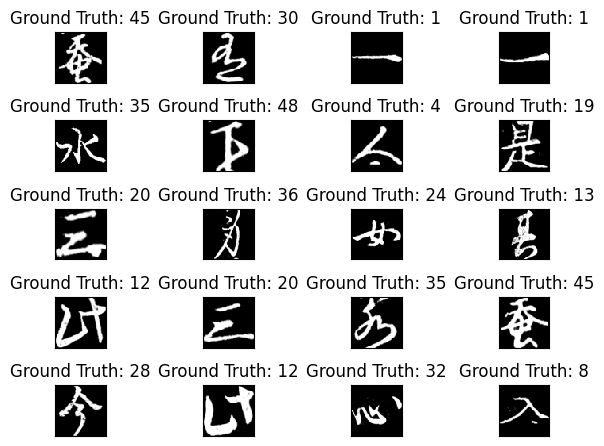

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]+1))
  plt.xticks([])
  plt.yticks([])
plt.show()

**Modelo de Red neuronal**

Esta red neuronal cuenta con 3 fases seguidas de convolución, ReLU y MaxPool, un par de drops para evitar overfitting, y linears para obtener finalmente las clasificaciones

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128*6*6, 128)
        self.fc2 = nn.Linear(128, 50)

    def forward(self, x): # Entrada de 1 canal y 64x64 pixeles (1,64,64)
        x = self.conv1(x) # Salida (32,64-3+1,64-3+1)=(32,62,62)
        x = F.relu(x) # Salida (32,62,62)
        x = self.pool1(x) # Salida (32,62/2,62/2)=(32,31,31)
        x = self.conv2(x) # Salida (64,31-3+1,31-3+1)=(64,29,29)
        x = F.relu(x) # Salida (64,29,29)
        x = self.pool2(x) # Salida (64,29/2,29/2)=(64,14,14)
        x = self.conv3(x) # Salida (128,14-3+1,14-3+1)=(128,12,12)
        x = F.relu(x) # Salida (128,12,12)
        x = self.pool3(x) # Salida (128,12/2,12/2)=(128,6,6)
        x = self.drop1(x) # Salida (128,6,6)
        x = x.flatten(1) # Salida (128x6x6)
        x = self.fc1(x) # Salida (128)
        x = F.relu(x) # Salida (128)
        x = self.drop2(x) # Salida (128)
        x = self.fc2(x) # Salida (50)
        x = F.log_softmax(x, dim=1)
        return x

**Entrenamiento del modelo**

Inicialización de los pesos

In [11]:
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

Cambiamos a "cuda" para poder utilizar la GPU en lugar de la CPU y tener un procesamiento más eficiente

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


Inicializamos el modelo, el optimizador y de tener el modelo ya entrenado lo podemos cargar, si se quiere entrenar desde 0 otro modelo se puede comentar la parte de "model.load_state_dict"

In [13]:
# Inicializar modelo
model = Net().to(device)
# Initializar pesos
model.apply(weights_init)
# Definir optimizador
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# Cargar modelo ya guardado (Comentar si se quiere empezar de 0)
model.load_state_dict(torch.load("modelo_kanji_50_completo2.pth",weights_only=False))


<All keys matched successfully>

Definimos nuestra función de entrenamiento

In [14]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Mover datos a GPU si está disponible
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Limpiar gradientes acumulados
        output = model(data)  # Forward pass
        loss = F.nll_loss(output, target)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos

        # Registro periódico
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

Definimos nuestra función de testeo

In [15]:
# Run on test data
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  # Desactiva gradientes
        for data, target in test_loader:
            # Mover datos a GPU si está disponible
            data, target = data.to(device), target.to(device)

            output = model(data)  # Forward pass
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Pérdida acumulada
            pred = output.argmax(dim=1, keepdim=True)  # Predicciones
            correct += pred.eq(target.view_as(pred)).sum().item()  # Acumular correctos

    # Pérdida promedio
    test_loss /= len(test_loader.dataset)

    # Imprimir resultados
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Realizamos el entrenamiento de nuestro modelo, el número de epocas se puede cambiar, además de usar un modelo cargado, este puede seguir entrenandose, para este caso se entrenó por 100 épocas al ser una fase de prueba

In [ ]:
import torch.nn.functional as F
# Get initial performance
test()
# Train for three epochs
n_epochs = 100
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Guardar el modelo que se tiene actualmente

In [26]:
torch.save(model.state_dict(), "modelo_kanji_50_completo2x.pth")

**Visualización de la validación**

Visualización de algunas predicciones de nuestra data de validación

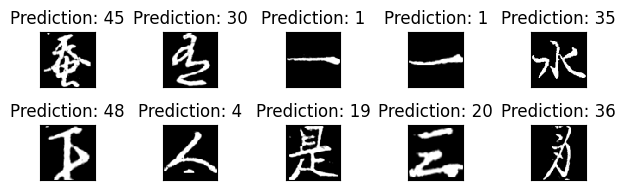

In [16]:
output = model(example_data.to(device))

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()+1))
  plt.xticks([])
  plt.yticks([])
plt.show()

**Prueba con pizarra**

Se realizó una pizarra interactiva, en esta dibujas un kanji y al hacer clic en "Predecir kanji" te muestra el kanji predicho, entonces al observar tanto el texto como el dibujo se sabe si se realizó de manera correcta, igualmente podemos guardar la imagen si vemos que es una predicción correcta con el botón de "Guardar imagen". Al ser pocos kanjis seleccionados se escribieron en un diccionario para poder visualizarlos luego en la pizarra al predecir.

In [17]:
import tkinter as tk
from tkinter import Button
import PIL.ImageGrab as ImageGrab
import cv2
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import numpy as np
import os

# Cargar el modelo entrenado
modelo = model.to(device)
modelo.eval()

# Diccionario de clases (ajusta según tu dataset)
kanji_classes = {1: "一", 2: "事", 3: "云", 4: "人", 5: "出", 6:"又", 7:"見", 8:"入", 9:"大", 10:"物", 11:"子",12:"此",13:"其",14:"也",15:"日",16:"小",17:"方",18:"上",19:"是",20:"三",21:"中",22:"何",23:"候",24:"女",25:"国",26:"二",27:"時",28:"今",29:"御",30:"有",31:"所",32:"心",33:"前",34:"合",35:"水",36:"身",37:"五",38:"山",39:"十",40:"同",41:"汁",42:"給",43:"手",44:"立",45:"蚕",46:"様",47:"之",48:"下",49:"吉",50:"世"}

# Crear la ventana
root = tk.Tk()
root.title("Pizarra de Kanji")

# Canvas de dibujo (ajustado para ser más grande que 28x28 para comodidad)
canvas_size = 256
canvas = tk.Canvas(root, width=canvas_size, height=canvas_size, bg="black")
canvas.pack()

image1 = Image.new("RGB", (canvas_size, canvas_size), (0,0,0))
draw2 = ImageDraw.Draw(image1)

# Variables para dibujar
def start_drawing(event):
    canvas.old_x, canvas.old_y = event.x, event.y

def draw(event):
    x, y = event.x, event.y
    canvas.create_line(canvas.old_x, canvas.old_y, x, y, width=10, fill="white", capstyle=tk.ROUND, smooth=tk.TRUE)
    draw2.line([canvas.old_x, canvas.old_y, x, y], (255,255,255),width=10)
    canvas.old_x, canvas.old_y = x, y

canvas.bind("<Button-1>", start_drawing)
canvas.bind("<B1-Motion>", draw)

ruta_del_archivo = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/contador.txt'
    
with open(ruta_del_archivo, 'r') as file:
        contenido = file.read()
contador=int(contenido)
# Función para guardar la imagen y predecir
def guardar_y_predecir():

    image1.save('C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kanjis_dibujados/img1.png')

    # Convertir a tensor y normalizar
    transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.Resize((64, 64)),  # Redimensionar las imágenes a 28x28 (como MNIST)
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((mean), (std,)),  # Normalizar las imágenes
])
    imagen_tensor = transform(image1).unsqueeze(0)  # Agregar dimensión batch

    # Hacer la predicción con el modelo
    imagen_tensor = imagen_tensor.to(device)
    salida = model(imagen_tensor)
    prediccion=salida.data.max(1, keepdim=True)[1].item()
    # Mostrar el resultado
    resultado_label.config(text=f"Predicción: {kanji_classes[prediccion+1]}")
    return prediccion

    
# Botón para guardar y predecir
boton_guardar = Button(root, text="Predecir Kanji", command=guardar_y_predecir)
boton_guardar.pack()

# Etiqueta para mostrar la predicción
resultado_label = tk.Label(root, text="Dibuja un Kanji y presiona 'Predecir Kanji'", font=("Arial", 14))
resultado_label.pack()

# Botón para limpiar la pizarra
# Función para limpiar el canvas y reiniciar la imagen
def limpiar_canvas():
    # Limpiar el canvas de dibujo
    canvas.delete("all")
    
    # Reiniciar la imagen asociada
    global image1, draw2
    image1 = Image.new("RGB", (canvas_size, canvas_size), (0, 0, 0))  # Nueva imagen en negro
    draw2 = ImageDraw.Draw(image1)  # Nuevo objeto ImageDraw para la imagen limpia

    

boton_limpiar = Button(root, text="Limpiar", command=limpiar_canvas)
boton_limpiar.pack()

root.mainloop()
